### Example on Echo State Networks (ESNs)

Following [tutorial on ESNs](https://towardsdatascience.com/predicting-stock-prices-with-echo-state-networks-f910809d23d4) and [review paper on ESNs](https://arxiv.org/abs/2012.02974) we will set up a basic ESN and compare performance to a classical CNN/LSTM hybrid network. Both will be applied on some timeseries of Amazon stock prices, given in the above mentioned tutorial.

#### Technical setup and data preparation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, Conv1D, LSTM, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.initializers as tfi
import tensorflow.keras.regularizers as tfr

In [2]:
# Read dataset amazon.txt, absolute values:
data_abs = open("../data/amazon.txt").read().split()
data_abs = np.array(data_abs).astype('float64')

In [3]:
# Convert absolute values to relative change values
data_rel_chg = np.zeros(len(data_abs))
for i in range(len(data_abs)):
    # first rel_chg is kept zero, since we don't know any better
    if i > 0:
        data_rel_chg[i] = (data_abs[i] - data_abs[i-1]) / data_abs[i-1]

In [4]:
# define function to split time series 'sequence' into 'n_steps'
def split_sequence(sequence, n_steps):
    X = list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x = sequence[i:end_ix]
        X.append(seq_x)
    return np.array(X)

#### Prepare inputs and targets for CNN/LSTM network

In [5]:
# Split data_rel_chg into sequences of specified input length.
# For now work with 16d, as in my master's thesis.
input_length = 16
data_rel_chg_split = split_sequence(data_rel_chg, input_length)
print("data shape after splitting: ", np.shape(data_rel_chg_split))

data shape after splitting:  (1785, 16)


In [6]:
# Create targets (1d rel_chg) from data_rel_chg, remove first input_length steps
target_rel_chg = data_rel_chg[input_length:]

# Now need to remove last input from data_rel_chg_split, since last input has no target.
data_rel_chg_split = data_rel_chg_split[:-1]

# check values and shape
print("data shape after removing last sample: ", data_rel_chg_split.shape)
print("targets shape: ", target_rel_chg.shape)

data shape after removing last sample:  (1784, 16)
targets shape:  (1784,)


In [7]:
# split data into train and validation set
train_input = data_rel_chg_split[:1500]
val_input = data_rel_chg_split[1500:]
train_target = target_rel_chg[:1500]
val_target = target_rel_chg[1500:]

# check dimensions
print("train_input: ", np.shape(train_input))
print("val_input: ", np.shape(val_input))
print("train_target: ", np.shape(train_target))
print("val_target: ", np.shape(val_target))

train_input:  (1500, 16)
val_input:  (284, 16)
train_target:  (1500,)
val_target:  (284,)


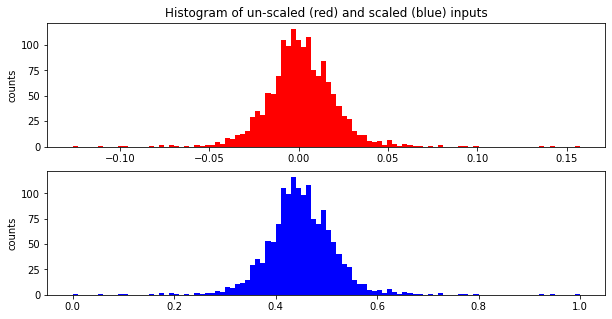

In [8]:
# prepare scaling of both sets according to min/max of ONLY train set
train_min = np.min(train_input)
train_max = np.max(train_input)

# scale input values and targets, according to min/min of ONLY train inputs:
# substract min and divide by (max - min)
train_input_norm = (train_input - train_min) / (train_max - train_min)
val_input_norm = (val_input - train_min) / (train_max - train_min)
train_target_norm = (train_target - train_min) / (train_max - train_min)
val_target_norm = (val_target - train_min) / (train_max - train_min)

# check distribution of input values before and after scaling
nBins = 100
fig, axes = plt.subplots(2, 1, figsize=(10,5))
axes[0].hist(train_input[:,0], nBins, color="red")
axes[0].set_ylabel("counts")
axes[0].set_title("Histogram of un-scaled (red) and scaled (blue) inputs")
axes[1].hist(train_input_norm[:,0], nBins, color="blue")
axes[1].set_ylabel("counts")
plt.show()

In [9]:
# Reshape input sets to have feature number as third dimension
train_input = np.reshape(train_input_norm, (np.shape(train_input_norm)[0], np.shape(train_input_norm)[1], 1))
val_input = np.reshape(val_input_norm, (np.shape(val_input_norm)[0], np.shape(val_input_norm)[1], 1))

# final dimension check
print("train_input: ", np.shape(train_input))
print("val_input: ", np.shape(val_input))

# number of input features
num_channels = 1

# input dimensions
input_shape = (np.shape(train_input)[1], num_channels)    
num_inputs = train_input.shape[1] * num_channels
num_outputs = 1 

# further parameters: weight/bias initialization
weight_init = tfi.glorot_uniform() # tfi.RandomUniform(minval=-0.05, maxval=0.05, seed=None)  tfi.RandomNormal()
bias_init = tfi.Zeros()

# further parameters: regularization
kernel_reg_CNN=tfr.l1_l2(l1=0, l2=0) # (l1=1e-5, l2=1e-4)
bias_reg_CNN=tfr.l2(0) # l2(1e-4) 
kernel_reg_LSTM=tfr.l1_l2(l1=0, l2=0) # (l1=1e-5, l2=1e-4)
bias_reg_LSTM=tfr.l2(0) # l2(1e-4) 
kernel_reg_Dense=tfr.l1_l2(l1=0, l2=0) # (l1=1e-5, l2=1e-4)
bias_reg_Dense=tfr.l2(0) # l2(1e-4) 

# batch size
batch_size = 20   

train_input:  (1500, 16, 1)
val_input:  (284, 16, 1)


#### Set up CNN-LSTM network

2022-02-03 05:34:38.008356: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 10, 10)            80        
_________________________________________________________________
batch_normalization (BatchNo (None, 10, 10)            40        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 10, 10)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 7, 20)             820       
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 20)             80        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 20)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 7, 20)             3

2022-02-03 05:34:38.253959: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


75/75 [==============================] - 2s 11ms/step - loss: 0.1128 - mae: 0.3196 - val_loss: 0.1295 - val_mae: 0.3545
Epoch 2/7
75/75 [==============================] - 0s 3ms/step - loss: 0.0239 - mae: 0.1294 - val_loss: 0.0475 - val_mae: 0.2094
Epoch 3/7
75/75 [==============================] - 0s 3ms/step - loss: 0.0092 - mae: 0.0701 - val_loss: 0.0137 - val_mae: 0.1022
Epoch 4/7
75/75 [==============================] - 0s 3ms/step - loss: 0.0068 - mae: 0.0617 - val_loss: 0.0053 - val_mae: 0.0506
Epoch 5/7
75/75 [==============================] - 0s 3ms/step - loss: 0.0077 - mae: 0.0631 - val_loss: 0.0047 - val_mae: 0.0480
Epoch 6/7
75/75 [==============================] - 0s 3ms/step - loss: 0.0069 - mae: 0.0596 - val_loss: 0.0047 - val_mae: 0.0492
Epoch 7/7
75/75 [==============================] - 0s 3ms/step - loss: 0.0068 - mae: 0.0596 - val_loss: 0.0047 - val_mae: 0.0476


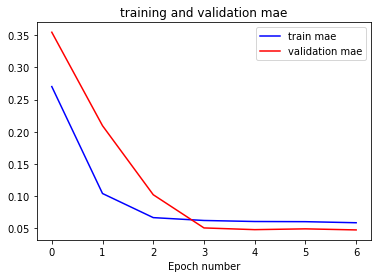

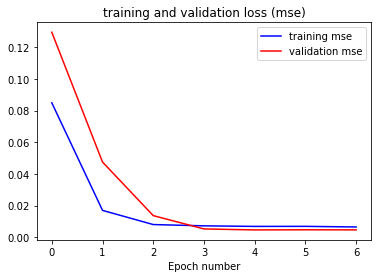

In [10]:
#########################################
# define model: hybrid CNN-LSTM         #
#########################################

model = Sequential()
model.add(Conv1D(filters=10, kernel_size=7, input_shape=input_shape, strides=1, kernel_initializer=weight_init, bias_initializer = bias_init, kernel_regularizer=kernel_reg_CNN, bias_regularizer=bias_reg_CNN))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.3))
model.add(Conv1D(filters=20, kernel_size=4, strides=1, kernel_initializer=weight_init, bias_initializer = bias_init, kernel_regularizer=kernel_reg_CNN, bias_regularizer=bias_reg_CNN))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.3))
model.add(LSTM(20, bias_initializer="zeros", return_sequences=True, kernel_regularizer=kernel_reg_LSTM, bias_regularizer=bias_reg_LSTM))
#model.add(Dropout(0.5))
model.add(LSTM(10, kernel_regularizer=kernel_reg_LSTM, bias_regularizer=bias_reg_LSTM))
#model.add(Dropout(0.5))
model.add(Dense(units=num_outputs, name = "output", activation = 'linear', kernel_initializer=weight_init, bias_initializer = bias_init, kernel_regularizer=kernel_reg_Dense, bias_regularizer=bias_reg_Dense))

# compile model (with constant lr)
model.compile(optimizer=Adam(learning_rate=0.0001),loss='mean_squared_error',metrics=['mae'])
model.summary()

# train model
history = model.fit(train_input, train_target_norm, epochs=7, batch_size=batch_size, shuffle=True, verbose=1, validation_data=(val_input, val_target_norm))

# plot train and validation mae
plt.plot(history.history['mae'], color = 'blue', label = 'train mae')
plt.plot(history.history['val_mae'], color = 'red', label = 'validation mae')
plt.xlabel('Epoch number')
plt.title('training and validation mae')
plt.legend()
plt.show()
    
# plot train and val_loss
plt.plot(history.history['loss'], color = 'blue', label = 'training mse')
plt.plot(history.history['val_loss'], color = 'red', label = 'validation mse')
plt.xlabel('Epoch number')
plt.title('training and validation loss (mse)')
plt.legend()
plt.show()  

#### Evaluate CNN/LSTM performance

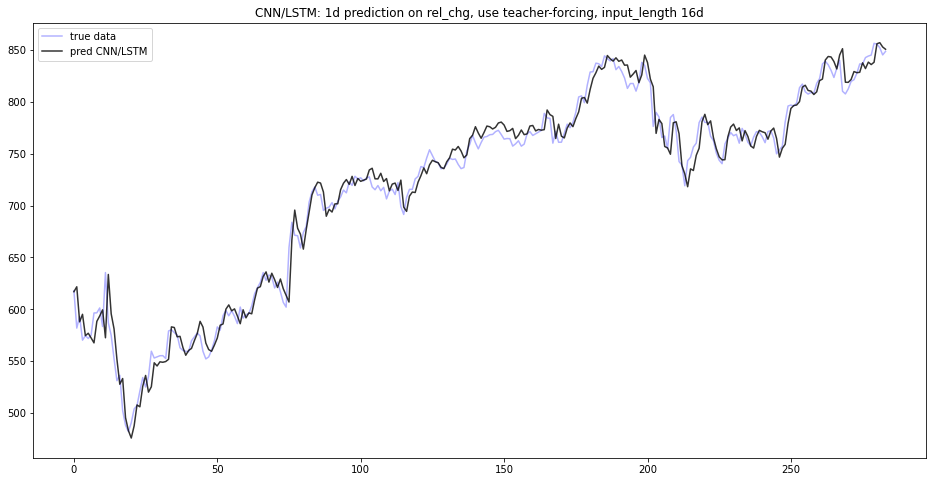

up movements percentage:  0.57
CNN/LSTM pred. accuracy:  0.539
CNN/LSTM mean abs. error:  9.3


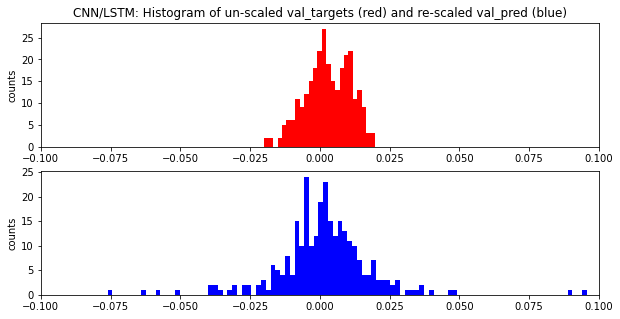

In [11]:
### Evaluate CNN/LSTM performance

# Get model prediction and reverse min/max scaling
val_pred = model.predict(val_input) * (train_max - train_min) + train_min

# convert back to absolute values, first need "last" absolute train input as basis
last_train_input_abs = data_abs[-(len(val_pred) + 1)]


### 1 step prediction with "teacher-forcing"
# Use predicted rel_chg for first step to get first absolute prediction. 
# Then replace this predicted absolute value by true absolute value to get second prediction of abs. value
# from second predicted rel_chg.

# as reference, need true absolute validation data
val_true_abs = data_abs[-len(val_pred):]

val_pred_abs = np.zeros(len(val_pred))
for i in range(len(val_pred)):
    # first value needs to hook on last_train_input_abs
    if i==0:
        val_pred_abs[i] = last_train_input_abs * (1 + val_pred[i])
    elif i>0:
        val_pred_abs[i] = val_true_abs[i-1] * (1 + val_pred[i])

# Fidelity check: Plot validation data, true vs. predicted absolute values
plt.figure(figsize=(16,8))
plt.plot(range(len(val_pred)),val_true_abs,'b',label="true data", alpha=0.3)
plt.plot(range(len(val_pred)),val_pred_abs,'k',  alpha=0.8, label='pred CNN/LSTM')
plt.title("CNN/LSTM: 1d prediction on rel_chg, use teacher-forcing, input_length 16d")
plt.legend()
plt.show() 

# check balance in up/down movements of validation data
print("up movements percentage: ", np.round(sum(val_target>=0) / len(val_target), 3))

# get prediction accuracy from rel. change prediction
print("CNN/LSTM pred. accuracy: ", np.round(sum((val_target >= 0) == (val_pred[:,0] >= 0)) / len(val_target), 3))

# get MAE from abs. values
print("CNN/LSTM mean abs. error: ", np.round(sum(np.abs(val_true_abs - val_pred_abs)) / len(val_target), 1))

# check distribution true un-scaled val_targets vs. re-scaled predicted validation output (rel_chg)
nBins1 = 25
nBins2 = 100
fig, axes = plt.subplots(2, 1, figsize=(10,5))
axes[0].hist(val_pred[:,0], nBins1, color="red")
axes[0].set_ylabel("counts")
axes[0].set_xlim(-0.1, 0.1)
axes[0].set_title("CNN/LSTM: Histogram of un-scaled val_targets (red) and re-scaled val_pred (blue)")
axes[1].hist(val_target, nBins2, color="blue")
axes[1].set_ylabel("counts")
axes[1].set_xlim(-0.1, 0.1)
plt.show()

In [12]:
print("val_input: ", np.shape(val_input))
print("val_target_norm: ", np.shape(val_target_norm))

val_input:  (284, 16, 1)
val_target_norm:  (284,)


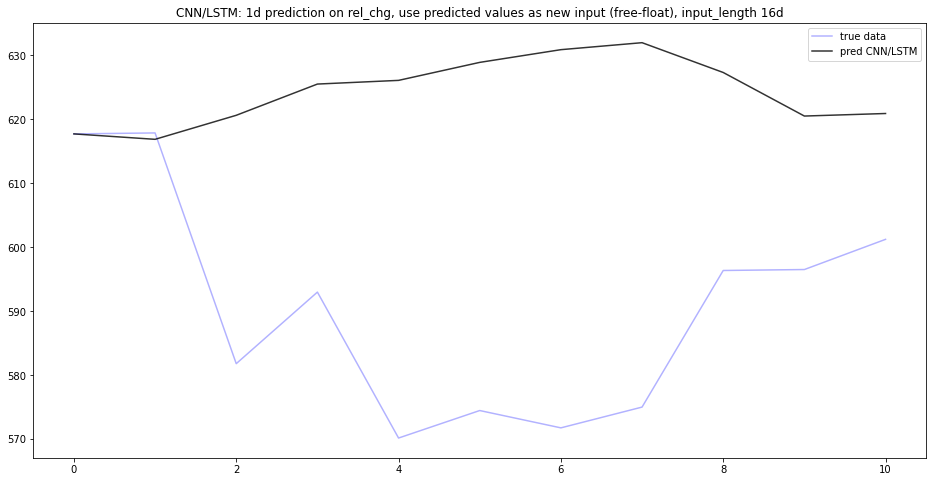

CNN/LSTM mean abs. error:  37.4


In [13]:
### Alternative: Instead of "teacher-forcing", we use predicted rel_chg values as input for next prediction step.
# "Free-floating" prediction over number of steps.

# Set number of free-float steps
n_steps = 10

# Fix first val_input, but need all three dimensions (num samples, num timesteps, num features)
temp_input = np.copy(val_input[0:1,:,0:1])

# Initialize array for storing free-float predictions.
val_pred_free = np.zeros(n_steps)

# Loop over number of free-float steps
for i in range (n_steps):
    
    # Get model prediction and reverse min/max scaling
    val_pred_free[i] = model.predict(temp_input)[0]
    
    # Shift last input series by one step and add prediction
    temp_input[0:1,:input_length-1,0:1] = temp_input[0:1,1:,0:1]
    temp_input[0,-1,0] = val_pred_free[i]

# Reverse min/max scaling on free-float prediction
val_pred_free_rescaled = val_pred_free * (train_max - train_min) + train_min

# Convert back to absolute values, first need "last" absolute train input as basis
last_train_input_abs = data_abs[-(len(val_pred) + 1)]

val_pred_free_abs = np.zeros(len(val_pred_free))
for i in range(len(val_pred_free)):
    # first value needs to hook on last_train_input_abs
    if i==0:
        val_pred_free_abs[i] = last_train_input_abs * (1 + val_pred_free_rescaled[i])
    elif i>0:
        val_pred_free_abs[i] = val_pred_free_abs[i-1] * (1 + val_pred_free_rescaled[i])
        
# As reference, need true absolute validation data, starting from "last" absolute train input as basis,
# then take n_steps
val_true_abs = data_abs[-len(val_pred):-len(val_pred)+n_steps]

# Fidelity check: Plot first n_steps of validation data, true vs. predicted absolute values.
# Note: Length (n_steps +1), since we want to show "last abs. input" as basis, 
# in addition to predicted abs. values.
plt.figure(figsize=(16,8))
plt.plot(range(n_steps+1),np.insert(val_true_abs, 0, last_train_input_abs),'b',label="true data", alpha=0.3)
plt.plot(range(n_steps+1),np.insert(val_pred_free_abs, 0, last_train_input_abs),'k',  alpha=0.8, label='pred CNN/LSTM')
plt.title("CNN/LSTM: 1d prediction on rel_chg, use predicted values as new input (free-float), input_length 16d")
plt.legend()
plt.show() 

# get MAE from abs. values
print("CNN/LSTM mean abs. error: ", np.round(sum(np.abs(val_true_abs - val_pred_free_abs)) / n_steps, 1))

#### Set up basic ESN network

val_target_norm:  (284,)
train_input_ESN:  (1500,)
train_target_norm:  (1500,)
W_in:  (500, 1)


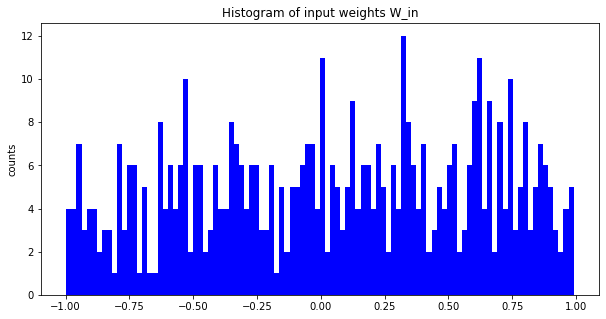

In [76]:
#########################################
# set up basic ESN on amazon data       #
# for comparability reasons use rel_chg #
#########################################

# Opposed to CNN/LSTM - where we used input length 16d to predict 1d target -
# here we use full training length to predict 1d target.
# Note: In CNN/LSTM model we used rel_chg data with min/max scaling: val_target_norm

print("val_target_norm: ", val_target_norm.shape)

### But let's first focus on training data:
# Train input for CNN/LSTM consists of 1500 samples of 16 timesteps each.
# Extract the last timesteps of each sample to get the input for ESN.
# Then have already min/max scaled rel_chg values:
train_input_ESN = train_input[:,-1,0]

print("train_input_ESN: ", train_input_ESN.shape)

# Train targets can be taken without change. Have already min/max scaled rel_chg targets from CNN/LSTM:
print("train_target_norm: ", train_target_norm.shape)

### prepare ESN
# So we have one input feature (D=1) with T=1500 timesteps, t=1..T
# Reservoir is set to N units (e.g. N=500)
# And we have only one output feature (M=1)
N = 500
T = len(train_input_ESN)

# initialize W_in from uniform distribution in [-1,1]
W_in = np.random.uniform(low=-1.0, high=1.0, size=(N,1))
print("W_in: ", W_in.shape)

# check distribution of W_in
nBins = 100
fig, axes = plt.subplots(1, 1, figsize=(10,5))
axes.hist(W_in[:,0], nBins, color="blue")
#axes.set_xlabel("scaled input weights")
axes.set_ylabel("counts")
axes.set_title("Histogram of input weights W_in")
plt.show()

In [77]:
### initialize W_res

# Sparsity is set to 0.2 and spectral_redius is set to 1.2, as in Tutorial.
sparsity = 0.2
spec_rad = 1.2

# Need temporary matrix W_temp to implement sparsity manually
W_temp = np.random.uniform(low=0, high=1, size=(500,500))
W_sparse = W_temp <= sparsity

# Then initialize W_full from uniform distribution in [-1,1]
W_full = np.random.uniform(low=-1.0, high=1.0, size=(500,500))

# Now apply sparsity to W
W = W_sparse * W_full

# get largest Eigenvalue of W
ev_max = np.max(np.real(np.linalg.eigvals(W)))

# finally set up W_res
W_res = spec_rad * W / ev_max

# quality check
print("W_res shape: ", W_res.shape)
print("W_res max: ", np.round(np.max(W_res),3))
print("W_res sparsity: ", np.round(sum(sum(W_res != 0)) / 250000, 3))

W_res shape:  (500, 500)
W_res max:  0.209
W_res sparsity:  0.199


In [78]:
### Get reservoir states X for all training input steps 1..T
# Note: Use tanh as activation.

# initialize X (N x T)
X = np.zeros((N,T))

for i in range(len(train_input_ESN)):
    # first step needs special treatment, since reservoir state is not yet initialized
    if i == 0:
        X[:,i:i+1] = np.tanh(W_in * train_input_ESN[i])
    elif i > 0:
        X[:,i:i+1] = np.tanh(W_in * train_input_ESN[i] + np.reshape(np.matmul(W_res, X[:,i-1]),(N,1)))

### Get output weights W_out from closed form solution

# first need pseudo-inverse of X, since X is not a square matrix
X_inv = np.linalg.pinv(X)

# then need Y, as desired training outputs (= training targets, min/max scaled rel_chg values)
Y = np.reshape(train_target_norm, (1,T))

# then get output weights
W_out = np.matmul(Y, X_inv)

# check dimensions        
print("X: ", X.shape)
print("Y: ", Y.shape)
print("W_in: ", W_in.shape)
print("W_res: ", W_res.shape)
print("W_out: ", W_out.shape)

X:  (500, 1500)
Y:  (1, 1500)
W_in:  (500, 1)
W_res:  (500, 500)
W_out:  (1, 500)


#### Evaluate ESN performance

val_target_norm:  (284,)
input_rel_chg_norm:  (1800,)


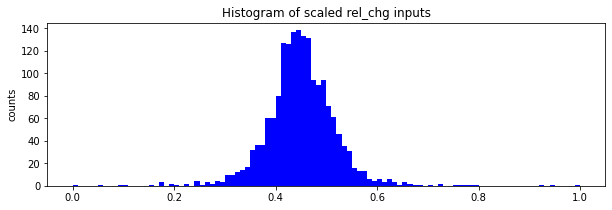

In [79]:
### prediction and evaluation of ESN

# Validation targets can be taken without change. Have already min/max scaled rel_chg targets from CNN/LSTM:
print("val_target_norm: ", val_target_norm.shape)

# Prepare validation inputs by applying min/max scaling on rel_chg data
input_rel_chg_norm = (data_rel_chg - train_min) / (train_max - train_min)
print("input_rel_chg_norm: ", input_rel_chg_norm.shape)

# check distribution of min/max scaled input_rel_chg
nBins = 100
fig, axes = plt.subplots(1, 1, figsize=(10,3))
axes.hist(input_rel_chg_norm, nBins, color="blue")
#axes.set_xlabel("scaled input values")
axes.set_ylabel("counts")
axes.set_title("Histogram of scaled rel_chg inputs")
plt.show()

In [80]:
### Get reservoir states X for all validation input steps 1..T (loop i) for all validation targets (loop j)
# Note: Use tanh as activation.

# Initialize Y_pred to store predictions on validation input
Y_pred = np.zeros(len(val_target_norm))

for j in range(len(val_target_norm)):
    
    # Get current validation inputs.
    # Remember: Last 284 values are validation targets, as in CNN/LSTM example.
    # We want to have input length T=1500d, as in training of ESN, as a sliding window
    val_input_temp = input_rel_chg_norm[input_length+j : input_length+T+j]
    
    # initialize X_temp for current target (N x T)
    X_temp = np.zeros((N,T))

    for i in range(T):

        # first step needs special treatment, since reservoir state is not yet initialized
        if i == 0:
            X_temp[:,i:i+1] = np.tanh(W_in * val_input_temp[i])
        elif i > 0:
            X_temp[:,i:i+1] = np.tanh(W_in * val_input_temp[i] + np.reshape(np.matmul(W_res, X_temp[:,i-1]),(N,1)))

    # get predicted output from trained W_out and last reservoir state
    Y_pred[j] = np.matmul(W_out, X_temp[:,-1])
    
# check dimension, predicted and true values (min/max scaled rel_chg)
print("Y_pred: ", Y_pred.shape)
print("val_target_norm: ", val_target_norm.shape)

Y_pred:  (284,)
val_target_norm:  (284,)


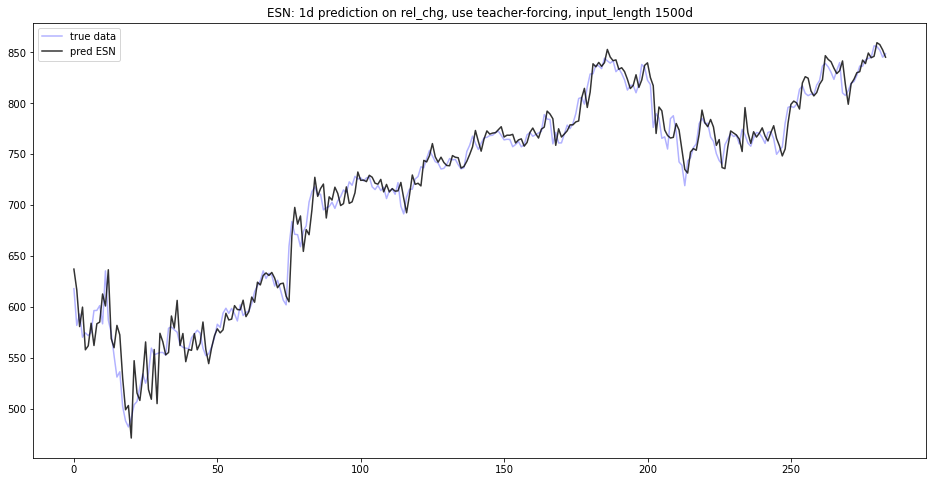

up movements percentage:  0.57
ESN pred. accuracy:  0.525
ESN mean abs. error:  10.6


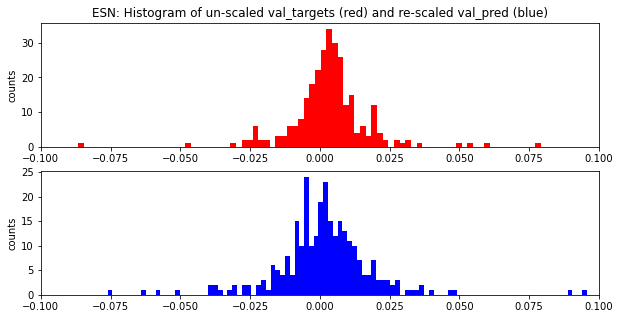

In [21]:
# reverse min/max scaling for predictions
Y_pred_rescaled = Y_pred * (train_max - train_min) + train_min

# convert back to absolute values, first need "last" absolute train input as basis
last_train_input_abs = data_abs[-(len(Y_pred) + 1)]

### 1 step prediction with "teacher-forcing"
# Use predicted rel_chg for first step to get first absolute prediction. 
# Then replace this predicted absolute value by true absolute value to get second prediction of abs. value
# from second predicted rel_chg.

# as reference, get true absolute validation data
Y_true_abs = data_abs[-len(Y_pred):]

Y_pred_abs = np.zeros(len(Y_pred))
for i in range(len(Y_pred)):
    # first value needs to hook on last_train_input_abs
    if i==0:
        Y_pred_abs[i] = last_train_input_abs * (1 + Y_pred_rescaled[i])
    elif i>0:
        Y_pred_abs[i] = Y_true_abs[i-1] * (1 + Y_pred_rescaled[i])

# Fidelity check: Plot validation data, true vs. predicted absolute values
plt.figure(figsize=(16,8))
plt.plot(range(len(Y_pred)),Y_true_abs,'b',label="true data", alpha=0.3)
plt.plot(range(len(Y_pred)),Y_pred_abs,'k',  alpha=0.8, label='pred ESN')
plt.title("ESN: 1d prediction on rel_chg, use teacher-forcing, input_length 1500d")
plt.legend()
plt.show() 

# check balance in up/down movements of validation data
print("up movements percentage: ", np.round(sum(val_target>=0) / len(val_target), 3))

# get prediction accuracy from rel. change prediction
print("ESN pred. accuracy: ", np.round(sum((val_target >= 0) == (Y_pred_rescaled >= 0)) / len(val_target), 3))

# get MAE from abs. values
print("ESN mean abs. error: ", np.round(sum(np.abs(Y_true_abs - Y_pred_abs)) / len(val_target), 1))

# check distribution true un-scaled val_targets vs. re-scaled predicted validation output (rel_chg)
nBins = 100
fig, axes = plt.subplots(2, 1, figsize=(10,5))
axes[0].hist(Y_pred_rescaled, nBins, color="red")
axes[0].set_ylabel("counts")
axes[0].set_xlim(-0.1, 0.1)
axes[0].set_title("ESN: Histogram of un-scaled val_targets (red) and re-scaled val_pred (blue)")
axes[1].hist(val_target, nBins, color="blue")
axes[1].set_ylabel("counts")
axes[1].set_xlim(-0.1, 0.1)
plt.show()

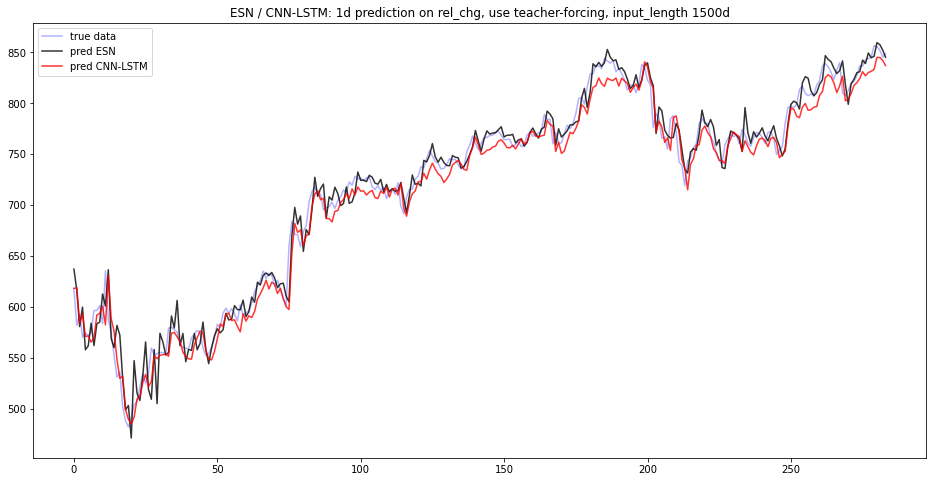

In [81]:
# Fidelity check: Plot validation data, true vs. predicted absolute values
plt.figure(figsize=(16,8))
plt.plot(range(len(Y_pred)),Y_true_abs,'b',label="true data", alpha=0.3)
plt.plot(range(len(Y_pred)),Y_pred_abs,'k',  alpha=0.8, label='pred ESN')
plt.plot(range(len(val_pred)),val_pred_abs,'r',  alpha=0.8, label='pred CNN-LSTM')
plt.title("ESN / CNN-LSTM: 1d prediction on rel_chg, use teacher-forcing, input_length 1500d")
plt.legend()
plt.show() 

In [82]:
### Alternative: Instead of "teacher-forcing", we use predicted rel_chg values as input for next prediction step.
# "Free-floating" prediction over number of steps.

# Set number of free-float steps
n_steps = 10

# Fix first val_input
val_input_temp = np.copy(input_rel_chg_norm[input_length : input_length+T])

# Initialize array for storing free-float predictions
Y_pred_free = np.zeros(n_steps)

### Get reservoir states X for all validation input steps 1..T (loop i) for all n_steps validation targets (loop j)
# Note: Use tanh as activation.

for j in range(n_steps):
    
    # initialize X_temp for current target (N x T)
    X_temp = np.zeros((N,T))

    for i in range(T):

        # first step needs special treatment, since reservoir state is not yet initialized
        if i == 0:
            X_temp[:,i:i+1] = np.tanh(W_in * val_input_temp[i])
        elif i > 0:
            X_temp[:,i:i+1] = np.tanh(W_in * val_input_temp[i] + np.reshape(np.matmul(W_res, X_temp[:,i-1]),(N,1)))

    # get predicted output from trained W_out and last reservoir state
    Y_pred_free[j] = np.matmul(W_out, X_temp[:,-1])
    
    # Shift last input series by one step and add prediction
    val_input_temp[:T-1] = val_input_temp[1:]
    val_input_temp[-1] = Y_pred_free[j]
    
    
# check dimension, predicted and true values (min/max scaled rel_chg)
print("Y_pred_free: ", Y_pred_free.shape)

Y_pred_free:  (10,)


In [83]:
# As reference, need true absolute validation data, starting from "last" absolute train input as basis,
# then take n_steps
val_true_abs = data_abs[-len(val_pred):-len(val_pred)+n_steps]
print("val_true_abs: ", val_true_abs.shape)

# Reverse min/max scaling on free-float prediction
Y_pred_free_rescaled = Y_pred_free * (train_max - train_min) + train_min

# Convert back to absolute values, first need "last" absolute train input as basis
last_train_input_abs = data_abs[-(len(val_pred) + 1)]

Y_pred_free_abs = np.zeros(len(Y_pred_free))
for i in range(n_steps):
    # first value needs to hook on last_train_input_abs
    if i==0:
        Y_pred_free_abs[i] = last_train_input_abs * (1 + Y_pred_free_rescaled[i])
    elif i>0:
        Y_pred_free_abs[i] = Y_pred_free_abs[i-1] * (1 + Y_pred_free_rescaled[i])
        
print("Y_pred_free_abs: ", Y_pred_free_abs.shape)

val_true_abs:  (10,)
Y_pred_free_abs:  (10,)


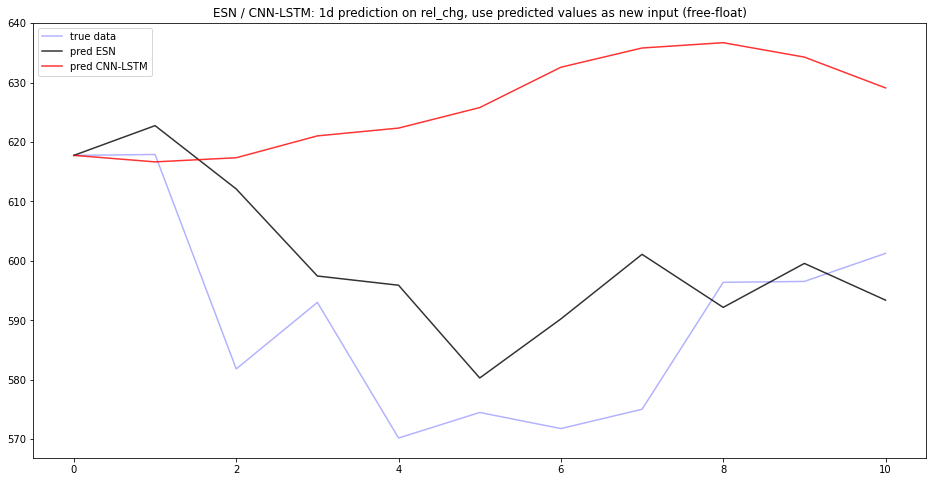

ESN mean abs. error:  13.1


In [86]:
# Fidelity check: Plot first n_steps of validation data, true vs. predicted absolute values.
# Note: Length (n_steps +1), since we want to show "last abs. input" as basis, 
# in addition to predicted abs. values.
plt.figure(figsize=(16,8))
plt.plot(range(n_steps+1),np.insert(val_true_abs, 0, last_train_input_abs),'b',label="true data", alpha=0.3)
plt.plot(range(n_steps+1),np.insert(Y_pred_free_abs, 0, last_train_input_abs),'k',  alpha=0.8, label='pred ESN')
plt.plot(range(n_steps+1),np.insert(val_pred_free_abs, 0, last_train_input_abs),'r',  alpha=0.8, label='pred CNN-LSTM')
plt.title("ESN / CNN-LSTM: 1d prediction on rel_chg, use predicted values as new input (free-float)")
plt.legend()
plt.show()

# get MAE from abs. values
print("ESN mean abs. error: ", np.round(sum(np.abs(val_true_abs - Y_pred_free_abs)) / n_steps, 1))

### Stability and Reproducibility check

Run CNN/LSTM and ESN multiple time (say 10 times) and keep track of:

* prediction accuracy
* mean absolute error with "teacher-forcing"
* mean absolute erros in "free-float" modus

In [32]:
### Multiple run CNN/LSTM model

# set number of runs
n_run = 20

# initialize storage arrays for evaluation metrics
CNNLSTM_accuracy = np.zeros(n_run)
CNNLSTM_mae_teacher = np.zeros(n_run)
CNNLSTM_mae_free = np.zeros(n_run)

for k in range(n_run):
    # set up model
    model = Sequential()
    model.add(Conv1D(filters=10, kernel_size=7, input_shape=input_shape, strides=1, kernel_initializer=weight_init, bias_initializer = bias_init, kernel_regularizer=kernel_reg_CNN, bias_regularizer=bias_reg_CNN))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.3))
    model.add(Conv1D(filters=20, kernel_size=4, strides=1, kernel_initializer=weight_init, bias_initializer = bias_init, kernel_regularizer=kernel_reg_CNN, bias_regularizer=bias_reg_CNN))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.3))
    model.add(LSTM(20, bias_initializer="zeros", return_sequences=True, kernel_regularizer=kernel_reg_LSTM, bias_regularizer=bias_reg_LSTM))
    #model.add(Dropout(0.5))
    model.add(LSTM(10, kernel_regularizer=kernel_reg_LSTM, bias_regularizer=bias_reg_LSTM))
    #model.add(Dropout(0.5))
    model.add(Dense(units=num_outputs, name = "output", activation = 'linear', kernel_initializer=weight_init, bias_initializer = bias_init, kernel_regularizer=kernel_reg_Dense, bias_regularizer=bias_reg_Dense))

    # compile model (with constant lr)
    model.compile(optimizer=Adam(learning_rate=0.0001),loss='mean_squared_error',metrics=['mae'])
    #model.summary()

    # train model
    history = model.fit(train_input, train_target_norm, epochs=7, batch_size=batch_size, shuffle=True, verbose=0, validation_data=(val_input, val_target_norm))

    ### Evaluate CNN/LSTM performance

    # Get model prediction and reverse min/max scaling
    val_pred = model.predict(val_input) * (train_max - train_min) + train_min

    # convert back to absolute values, first need "last" absolute train input as basis
    last_train_input_abs = data_abs[-(len(val_pred) + 1)]

    ### 1 step prediction with "teacher-forcing"
    # Use predicted rel_chg for first step to get first absolute prediction. 
    # Then replace this predicted absolute value by true absolute value to get second prediction of abs. value
    # from second predicted rel_chg.

    # as reference, need true absolute validation data
    val_true_abs = data_abs[-len(val_pred):]

    val_pred_abs = np.zeros(len(val_pred))
    for i in range(len(val_pred)):
        # first value needs to hook on last_train_input_abs
        if i==0:
            val_pred_abs[i] = last_train_input_abs * (1 + val_pred[i])
        elif i>0:
            val_pred_abs[i] = val_true_abs[i-1] * (1 + val_pred[i])


    # store accuracy and mae (with "teacher forcing")
    CNNLSTM_accuracy[k] = np.round(sum((val_target >= 0) == (val_pred[:,0] >= 0)) / len(val_target), 3)
    CNNLSTM_mae_teacher[k] = np.round(sum(np.abs(val_true_abs - val_pred_abs)) / len(val_target), 1)


    ### Alternative: Instead of "teacher-forcing", we use predicted rel_chg values as input for next prediction step.
    # "Free-floating" prediction over number of steps.

    # Set number of free-float steps
    n_steps = 10

    # Fix first val_input, but need all three dimensions (num samples, num timesteps, num features)
    temp_input = np.copy(val_input[0:1,:,0:1])

    # Initialize array for storing free-float predictions.
    val_pred_free = np.zeros(n_steps)

    # Loop over number of free-float steps
    for i in range (n_steps):

        # Get model prediction and reverse min/max scaling
        val_pred_free[i] = model.predict(temp_input)[0]

        # Shift last input series by one step and add prediction
        temp_input[0:1,:input_length-1,0:1] = temp_input[0:1,1:,0:1]
        temp_input[0,-1,0] = val_pred_free[i]

    # Reverse min/max scaling on free-float prediction
    val_pred_free_rescaled = val_pred_free * (train_max - train_min) + train_min

    # Convert back to absolute values, first need "last" absolute train input as basis
    last_train_input_abs = data_abs[-(len(val_pred) + 1)]

    val_pred_free_abs = np.zeros(len(val_pred_free))
    for i in range(len(val_pred_free)):
        # first value needs to hook on last_train_input_abs
        if i==0:
            val_pred_free_abs[i] = last_train_input_abs * (1 + val_pred_free_rescaled[i])
        elif i>0:
            val_pred_free_abs[i] = val_pred_free_abs[i-1] * (1 + val_pred_free_rescaled[i])

    # As reference, need true absolute validation data, starting from "last" absolute train input as basis,
    # then take n_steps
    val_true_abs = data_abs[-len(val_pred):-len(val_pred)+n_steps]


    # store mae ("free-float" modus)
    CNNLSTM_mae_free[k] = np.round(sum(np.abs(val_true_abs - val_pred_free_abs)) / n_steps, 1)

In [33]:
### Multiple run ESN model

# set number of runs
n_run = 20

# initialize storage arrays for evaluation metrics
ESN_accuracy = np.zeros(n_run)
ESN_mae_teacher = np.zeros(n_run)
ESN_mae_free = np.zeros(n_run)

for k in range(n_run):
    
    # Opposed to CNN/LSTM - where we used input length 16d to predict 1d target -
    # here we use full training length to predict 1d target.
    # Note: In CNN/LSTM model we used rel_chg data with min/max scaling: val_target_norm

    ### But let's first focus on training data:
    # Train input for CNN/LSTM consists of 1500 samples of 16 timesteps each.
    # Extract the last timesteps of each sample to get the input for ESN.
    # Then have already min/max scaled rel_chg values:
    train_input_ESN = train_input[:,-1,0]

    # Train targets can be taken without change. Have already min/max scaled rel_chg targets from CNN/LSTM:

    ### prepare ESN
    # So we have one input feature (D=1) with T=1500 timesteps, t=1..T
    # Reservoir is set to N units (e.g. N=500)
    # And we have only one output feature (M=1)
    N = 500
    T = len(train_input_ESN)

    # initialize W_in from uniform distribution in [-1,1]
    W_in = np.random.uniform(low=-1.0, high=1.0, size=(N,1))

    ### initialize W_res

    # Sparsity is set to 0.2 and spectral_redius is set to 1.2, as in Tutorial.
    sparsity = 0.2
    spec_rad = 1.2

    # Need temporary matrix W_temp to implement sparsity manually
    W_temp = np.random.uniform(low=0, high=1, size=(500,500))
    W_sparse = W_temp <= sparsity

    # Then initialize W_full from uniform distribution in [-1,1]
    W_full = np.random.uniform(low=-1.0, high=1.0, size=(500,500))

    # Now apply sparsity to W
    W = W_sparse * W_full

    # get largest Eigenvalue of W
    ev_max = np.max(np.real(np.linalg.eigvals(W)))

    # finally set up W_res
    W_res = spec_rad * W / ev_max

    ### Get reservoir states X for all training input steps 1..T
    # Note: Use tanh as activation.

    # initialize X (N x T)
    X = np.zeros((N,T))

    for i in range(len(train_input_ESN)):
        # first step needs special treatment, since reservoir state is not yet initialized
        if i == 0:
            X[:,i:i+1] = np.tanh(W_in * train_input_ESN[i])
        elif i > 0:
            X[:,i:i+1] = np.tanh(W_in * train_input_ESN[i] + np.reshape(np.matmul(W_res, X[:,i-1]),(N,1)))

    ### Get output weights W_out from closed form solution

    # first need pseudo-inverse of X, since X is not a square matrix
    X_inv = np.linalg.pinv(X)

    # then need Y, as desired training outputs (= training targets, min/max scaled rel_chg values)
    Y = np.reshape(train_target_norm, (1,T))

    # then get output weights
    W_out = np.matmul(Y, X_inv)

    ### prediction and evaluation of ESN

    # Validation targets can be taken without change. Have already min/max scaled rel_chg targets from CNN/LSTM:

    # Prepare validation inputs by applying min/max scaling on rel_chg data
    input_rel_chg_norm = (data_rel_chg - train_min) / (train_max - train_min)

    ### Get reservoir states X for all validation input steps 1..T (loop i) for all validation targets (loop j)
    # Note: Use tanh as activation.

    # Initialize Y_pred to store predictions on validation input
    Y_pred = np.zeros(len(val_target_norm))

    for j in range(len(val_target_norm)):

        # Get current validation inputs.
        # Remember: Last 284 values are validation targets, as in CNN/LSTM example.
        # We want to have input length T=1500d, as in training of ESN, as a sliding window
        val_input_temp = input_rel_chg_norm[input_length+j : input_length+T+j]

        # initialize X_temp for current target (N x T)
        X_temp = np.zeros((N,T))

        for i in range(T):

            # first step needs special treatment, since reservoir state is not yet initialized
            if i == 0:
                X_temp[:,i:i+1] = np.tanh(W_in * val_input_temp[i])
            elif i > 0:
                X_temp[:,i:i+1] = np.tanh(W_in * val_input_temp[i] + np.reshape(np.matmul(W_res, X_temp[:,i-1]),(N,1)))

        # get predicted output from trained W_out and last reservoir state
        Y_pred[j] = np.matmul(W_out, X_temp[:,-1])

    # reverse min/max scaling for predictions
    Y_pred_rescaled = Y_pred * (train_max - train_min) + train_min

    # convert back to absolute values, first need "last" absolute train input as basis
    last_train_input_abs = data_abs[-(len(Y_pred) + 1)]

    ### 1 step prediction with "teacher-forcing"
    # Use predicted rel_chg for first step to get first absolute prediction. 
    # Then replace this predicted absolute value by true absolute value to get second prediction of abs. value
    # from second predicted rel_chg.

    # as reference, get true absolute validation data
    Y_true_abs = data_abs[-len(Y_pred):]

    Y_pred_abs = np.zeros(len(Y_pred))
    for i in range(len(Y_pred)):
        # first value needs to hook on last_train_input_abs
        if i==0:
            Y_pred_abs[i] = last_train_input_abs * (1 + Y_pred_rescaled[i])
        elif i>0:
            Y_pred_abs[i] = Y_true_abs[i-1] * (1 + Y_pred_rescaled[i])


    # store accuracy and mae (with "teacher forcing")
    ESN_accuracy[k] = np.round(sum((val_target >= 0) == (Y_pred_rescaled >= 0)) / len(val_target), 3)
    ESN_mae_teacher[k] = np.round(sum(np.abs(Y_true_abs - Y_pred_abs)) / len(val_target), 1)


    ### Alternative: Instead of "teacher-forcing", we use predicted rel_chg values as input for next prediction step.
    # "Free-floating" prediction over number of steps.

    # Set number of free-float steps
    n_steps = 10

    # Fix first val_input
    val_input_temp = np.copy(input_rel_chg_norm[input_length : input_length+T])

    # Initialize array for storing free-float predictions
    Y_pred_free = np.zeros(n_steps)

    ### Get reservoir states X for all validation input steps 1..T (loop i) for all n_steps validation targets (loop j)
    # Note: Use tanh as activation.

    for j in range(n_steps):

        # initialize X_temp for current target (N x T)
        X_temp = np.zeros((N,T))

        for i in range(T):

            # first step needs special treatment, since reservoir state is not yet initialized
            if i == 0:
                X_temp[:,i:i+1] = np.tanh(W_in * val_input_temp[i])
            elif i > 0:
                X_temp[:,i:i+1] = np.tanh(W_in * val_input_temp[i] + np.reshape(np.matmul(W_res, X_temp[:,i-1]),(N,1)))

        # get predicted output from trained W_out and last reservoir state
        Y_pred_free[j] = np.matmul(W_out, X_temp[:,-1])

        # Shift last input series by one step and add prediction
        val_input_temp[:T-1] = val_input_temp[1:]
        val_input_temp[-1] = Y_pred_free[j]

       # As reference, need true absolute validation data, starting from "last" absolute train input as basis,
    # then take n_steps
    val_true_abs = data_abs[-len(val_pred):-len(val_pred)+n_steps]

    # Reverse min/max scaling on free-float prediction
    Y_pred_free_rescaled = Y_pred_free * (train_max - train_min) + train_min

    # Convert back to absolute values, first need "last" absolute train input as basis
    last_train_input_abs = data_abs[-(len(val_pred) + 1)]

    Y_pred_free_abs = np.zeros(len(Y_pred_free))
    for i in range(n_steps):
        # first value needs to hook on last_train_input_abs
        if i==0:
            Y_pred_free_abs[i] = last_train_input_abs * (1 + Y_pred_free_rescaled[i])
        elif i>0:
            Y_pred_free_abs[i] = Y_pred_free_abs[i-1] * (1 + Y_pred_free_rescaled[i])


    # store mae ("free-float" modus)
    ESN_mae_free[k] = np.round(sum(np.abs(val_true_abs - Y_pred_free_abs)) / n_steps, 1)

CNN-LSTM metrics
accuracy:  [0.465 0.468 0.412 0.539 0.451 0.444 0.588 0.482 0.447 0.479]
mae_teacher:  [ 9.6 13.  10.7  9.2  9.5 13.5 10.   8.8  9.3 10.1]
mae_free:  [23.5 20.4 26.  26.6 14.1 27.5 76.4 19.1 18.4 46.1]

ESN metrics
accuracy:  [0.514 0.507 0.525 0.542 0.549 0.542 0.518 0.507 0.542 0.528]
mae_teacher:  [10.9 10.6 11.2  9.8 10.8 10.3 11.  10.5 11.2 10.1]
mae_free:  [35.6 16.9 47.4 38.9 35.6 29.6 47.6 44.1 17.2 15.2]


[Text(1, 0, 'CNN/LSTM'), Text(2, 0, 'ESN')]

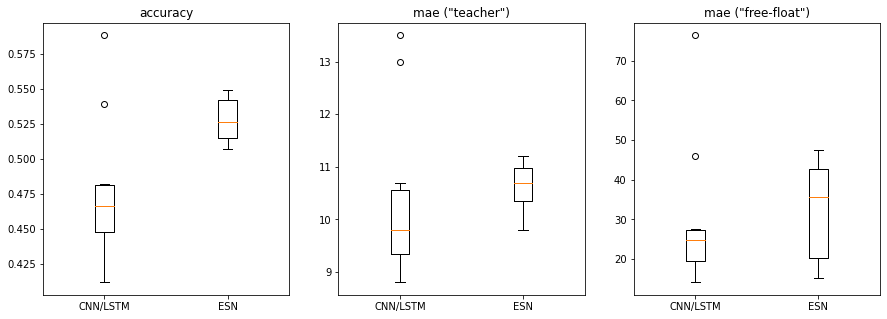

In [31]:
### Evaluate performance metrics for multiple runs (n_run) of CNN/LSTM model

## print raw arrays

print("CNN-LSTM metrics")
print("================")
print("accuracy: ", CNNLSTM_accuracy)
print("mae_teacher: ", CNNLSTM_mae_teacher)
print("mae_free: ", CNNLSTM_mae_free)
print("\nESN metrics")
print("================")
print("accuracy: ", ESN_accuracy)
print("mae_teacher: ", ESN_mae_teacher)
print("mae_free: ", ESN_mae_free)

# stack arrays to show as preparation for joint boxplot
joint_accuracy = np.stack((CNNLSTM_accuracy, ESN_accuracy), axis=1)
joint_mae_teacher = np.stack((CNNLSTM_mae_teacher, ESN_mae_teacher), axis=1)
joint_mae_free = np.stack((CNNLSTM_mae_free, ESN_mae_free), axis=1)

# Boxplots:
# Shows median as orange line, rectangle box specifies Q1 and Q3 (25% and 75% percentile), defining IQR
# and whiskers show Q1 - 1.5*IQR and Q3 + 1.5*IQR, circles mark outliers.
fig, axes = plt.subplots(1, 3, figsize=(15,5))
axes[0].set_title('accuracy')
axes[0].boxplot(joint_accuracy)
axes[0].set_xticklabels(['CNN/LSTM', 'ESN'])
axes[1].set_title('mae ("teacher")')
axes[1].boxplot(joint_mae_teacher)
axes[1].set_xticklabels(['CNN/LSTM', 'ESN'])
axes[2].set_title('mae ("free-float")')
axes[2].boxplot(joint_mae_free)
axes[2].set_xticklabels(['CNN/LSTM', 'ESN'])

CNN-LSTM metrics
accuracy:  [0.437 0.577 0.521 0.44  0.56  0.479 0.525 0.44  0.504 0.486 0.451 0.405
 0.525 0.556 0.454 0.57  0.444 0.549 0.468 0.563]
mae_teacher:  [11.5  8.8  8.7  9.8 10.5 10.7  9.4  9.8 10.1  9.2  9.9  9.2  9.5  9.3
 10.1 10.6  9.6  9.1  9.5  8.7]
mae_free:  [28.8 37.4 47.6 18.7 28.7 17.6 29.5 22.3 37.9 18.3  7.1 24.5 16.8 20.2
 21.  24.3 20.9 28.6 16.8 39.6]

ESN metrics
accuracy:  [0.56  0.57  0.563 0.482 0.489 0.563 0.514 0.532 0.535 0.549 0.532 0.528
 0.542 0.532 0.57  0.518 0.504 0.553 0.535 0.496]
mae_teacher:  [ 9.5  9.8 10.7 11.  11.3  9.5 10.9 11.4 10.4 10.  10.4 10.9 11.4  9.5
 10.8 11.5 10.7 10.5 10.2 11.9]
mae_free:  [30.5 42.2 13.3 30.9 25.2 31.8 41.4 17.7 37.2 23.1 47.2 57.1 40.3 43.3
 47.7 57.6 12.4 18.9 19.1 16.2]


[Text(1, 0, 'CNN/LSTM'), Text(2, 0, 'ESN')]

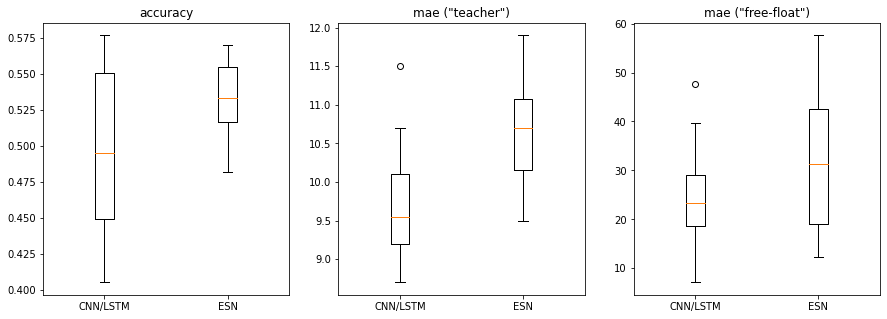

In [34]:
### Evaluate performance metrics for multiple runs (n_run) of CNN/LSTM model

## print raw arrays

print("CNN-LSTM metrics")
print("================")
print("accuracy: ", CNNLSTM_accuracy)
print("mae_teacher: ", CNNLSTM_mae_teacher)
print("mae_free: ", CNNLSTM_mae_free)
print("\nESN metrics")
print("================")
print("accuracy: ", ESN_accuracy)
print("mae_teacher: ", ESN_mae_teacher)
print("mae_free: ", ESN_mae_free)

# stack arrays to show as preparation for joint boxplot
joint_accuracy = np.stack((CNNLSTM_accuracy, ESN_accuracy), axis=1)
joint_mae_teacher = np.stack((CNNLSTM_mae_teacher, ESN_mae_teacher), axis=1)
joint_mae_free = np.stack((CNNLSTM_mae_free, ESN_mae_free), axis=1)

# Boxplots:
# Shows median as orange line, rectangle box specifies Q1 and Q3 (25% and 75% percentile), defining IQR
# and whiskers show Q1 - 1.5*IQR and Q3 + 1.5*IQR, circles mark outliers.
fig, axes = plt.subplots(1, 3, figsize=(15,5))
axes[0].set_title('accuracy')
axes[0].boxplot(joint_accuracy)
axes[0].set_xticklabels(['CNN/LSTM', 'ESN'])
axes[1].set_title('mae ("teacher")')
axes[1].boxplot(joint_mae_teacher)
axes[1].set_xticklabels(['CNN/LSTM', 'ESN'])
axes[2].set_title('mae ("free-float")')
axes[2].boxplot(joint_mae_free)
axes[2].set_xticklabels(['CNN/LSTM', 'ESN'])